- CNN pour la clacification du dataset avec les 10 catégorie https://keras.io/api/datasets/cifar10/
- Model inspiration : [link](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
- Fine tuning de mobilenet (ajout d'un dense layer pour catégorisation)

## Step 0: Mac M2 GPU

- The Neural Engine is primarily used for inference through Core ML
- TensorFlow training uses the GPU cores via Metal Performance Shaders (MPS)
- As of 2024, use Python 3.11 with TensorFlow 2.15.1 and tensorflow-metal 1.1.0 for best compatibility

In [125]:
%pip install tensorflow-metal
%pip install tensorflow-macos

# Step 1: System Information and TensorFlow Configuration
import sys
import platform
import subprocess
import tensorflow as tf

print("="*80)
print(" "*25 + "SYSTEM INFORMATION")
print("="*80)

# System details
print(f"\n📱 Platform: {platform.platform()}")
print(f"🏗️ Architecture: {platform.machine()}")
print(f"🐍 Python Version: {sys.version}")
print(f"📦 TensorFlow Version: {tf.__version__}")

# Check for tensorflow-metal
try:
    import tensorflow_metal
    print(f"TensorFlow Metal: Installed")
except ImportError:
    print("TensorFlow Metal: Not installed - GPU acceleration unavailable!")
    print("   Install with: pip install tensorflow-metal")

# Check macOS version
try:
    macos_version = subprocess.check_output(['sw_vers', '-productVersion']).decode().strip()
    print(f"macOS Version: {macos_version}")
    
    # Verify minimum version (12.0 required for Metal)
    major, minor = map(int, macos_version.split('.')[:2])
    if major < 12:
        print("WARNING: macOS 12.0+ required for Metal GPU support!")
except:
    pass

print("\n" + "="*80)
print(" "*25 + "GPU DETECTION & VERIFICATION")
print("="*80)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
                         SYSTEM INFORMATION

📱 Platform: macOS-15.6.1-arm64-arm-64bit
🏗️ Architecture: arm64
🐍 Python Version: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
📦 TensorFlow Version: 2.16.2
TensorFlow Metal: Not installed - GPU acceleration unavailable!
   Install with: pip install tensorflow-metal
macOS Version: 15.6.1

                         GPU DETECTION & VERIFICATION


In [126]:
# Step 2: GPU Detection and Configuration
print("\n Detecting available devices...")

# List all physical devices
devices = tf.config.list_physical_devices()
print(f"\nAll devices found: {len(devices)}")
for device in devices:
    print(f"   - {device}")

# Check specifically for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU DETECTED! Found {len(gpus)} GPU device(s)")
    for i, gpu in enumerate(gpus):
        print(f"\nGPU {i} Details:")
        print(f"   Device: {gpu}")
        try:
            details = tf.config.experimental.get_device_details(gpu)
            for key, value in details.items():
                print(f"   {key}: {value}")
        except:
            print(" (Unable to get detailed GPU information)")
    
    # Configure GPU memory growth
    print("\n Configuring GPU memory growth...")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" Memory growth enabled - GPU will allocate memory as needed")
    except RuntimeError as e:
        print(f" Could not set memory growth: {e}")
        
else:
    print("\n NO GPU DETECTED!")
    print("   Possible reasons:")
    print("   1. tensorflow-metal not installed")
    print("   2. Incompatible TensorFlow version")
    print("   3. System doesn't have compatible GPU")
    print("\n   To install tensorflow-metal:")
    print("   pip install tensorflow-metal==1.1.0")

# Enable device placement logging
print("\n📍 Enabling device placement logging...")
tf.debugging.set_log_device_placement(False)


 Detecting available devices...

All devices found: 2
   - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

GPU DETECTED! Found 1 GPU device(s)

GPU 0 Details:
   Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
   device_name: METAL

 Configuring GPU memory growth...
 Memory growth enabled - GPU will allocate memory as needed

📍 Enabling device placement logging...


# Step 1: Initialisation

In [127]:
# MINIMAL REQUIREMENTS 

# Python 
import sys
assert sys.version_info >= (3,11)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# COLAB DETECTION 

try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TENSORFLOW
import tensorflow as tf
assert tf.__version__ >= "2.16"


# COMMON IMPORTS
import numpy as np
import os
from datetime import datetime


# REPRODUCTIBILITY
np.random.seed(42)
tf.random.set_seed(42)

# MATPLOTLIB CONFIGURATION
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




# Step 2: load the data

In [128]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()


# Step : Data preparation

In [129]:
# Create the validation set from the train set
# Take 20% (0.2) of the total set (50000 * 0.2 = 10000 record)
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# One hot encode target values
y_train_new = tf.keras.utils.to_categorical(y_train_new, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Format in float32 and normalize to [0,1]
X_train_new = X_train_new.astype('float32') / 255.0
X_val       = X_val.astype('float32') / 255.0
X_test      = X_test.astype('float32') / 255.0

# Define class name
classNames = ['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']




# Step : Display data and stuff

(40000, 10)
(10000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


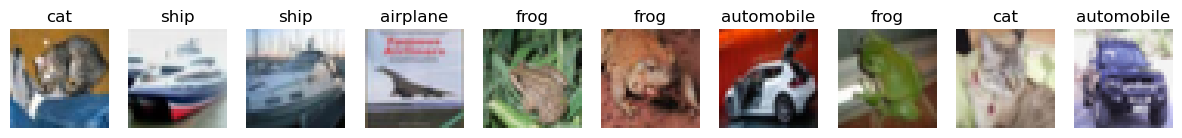

In [130]:
print(y_train_new.shape)
print(y_val.shape)
print(y_test.shape)

print(y_train_new[0])
print(y_val[0])
print(y_test[0])

fig, ax = plt.subplots(1, 10, figsize=(15,2))
for i in range(10):
    ax[i].axis('off')
    cls_idx = np.argmax(y_test[i])
    ax[i].set_title(classNames[cls_idx])
    ax[i].imshow(X_test[i])
plt.show()

# Step : Define models

In [131]:
'''
    small : Start simple
    - Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    medium : Add 1 layer with Conv 128
    - Layer 1 : 2 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 2 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 2 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    large : Add 1 Conv in each layer
    - Layer 1 : 3 x (Conv 32 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 128 + BatchNorm + Dropout(0.5) + Dense soft max

    large-wide : Double filters on each layer + adapte dense layer to match
    - Layer 1 : 3 x (Conv 64 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 16) + Dropout(0.1)
    - Layer 2 : 3 x (Conv 128 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 8) + Dropout(0.2)
    - Layer 3 : 3 x (Conv 256 filter 3x3 (Relu) + BatchNorm) + MaxPool2D (Reduce to 4) + Dropout(0.3)
    - Layer 4 : Flatten + Dense 256 + BatchNorm + Dropout(0.5) + Dense soft max

'''

def create_model(model_name="small"):
    if model_name == "small":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "medium":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "large":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    elif model_name == "large_wide":
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(32, 32, 3)),

            # Block 1
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.1),

            # Block 2
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.2),

            # Block 3
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu", kernel_initializer='he_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(2),
            tf.keras.layers.Dropout(0.3),

            # Dense head
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation="softmax")
        ])

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model


# Step : Define optimizers

In [132]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


# Step : Compile and display the model

In [133]:

model = create_model("small") 
model.compile(loss="categorical_crossentropy",
              optimizer=opt, 
              metrics=['accuracy'])
# Show model shape
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_220 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_248         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_221 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_249         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_222 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_250         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_223 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_251         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_252         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

# Step : Preprocess for training

In [134]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train the small model

In [ ]:
history_small = model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.4628 - loss: 1.5790 - val_accuracy: 0.6167 - val_loss: 1.0691
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.6260 - loss: 1.0632 - val_accuracy: 0.6968 - val_loss: 0.8679
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6824 - loss: 0.9038 - val_accuracy: 0.7107 - val_loss: 0.8241
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.7162 - loss: 0.8120 - val_accuracy: 0.7388 - val_loss: 0.7396
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.7401 - loss: 0.7435 - val_accuracy: 0.7170 - val_loss: 0.8173
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.7624 - loss: 0.6897 - val_accuracy: 0.7533 - val_loss: 0.7112
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.7764 - loss: 0.6448 - val_accuracy: 0.7323 - val_loss: 0.7892
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.7915 - loss: 0.6025 - 

# Step : Define Plot function

In [136]:

def plot_result(history):
    # Create subplots for Accuracy and Loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Step : Run plot results function

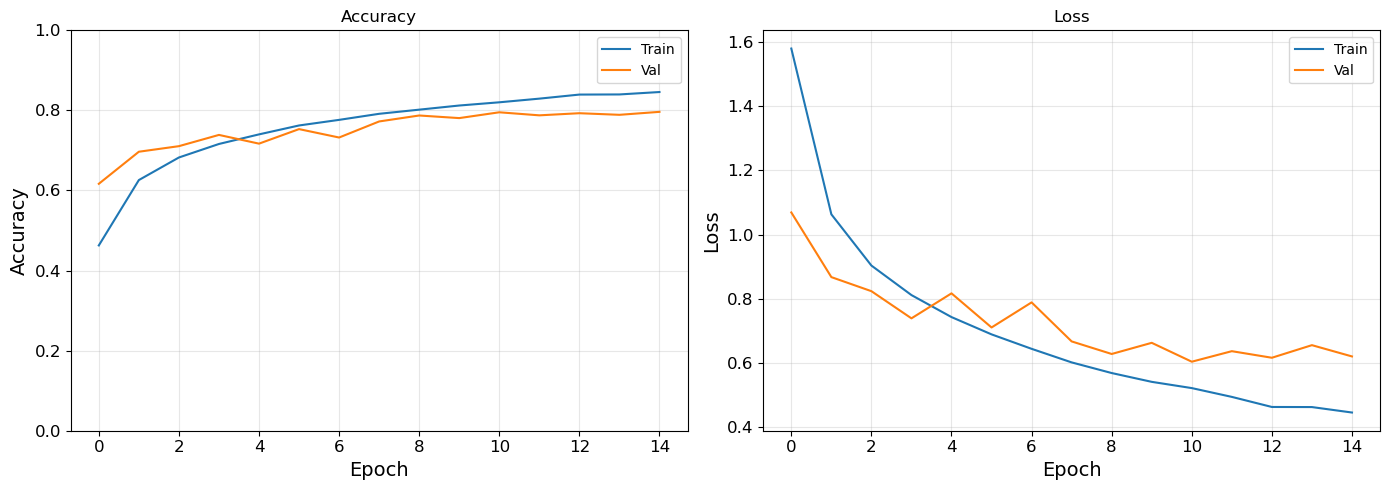

In [137]:
plot_result(history_small)

# Step : Define Evaluation function

In [138]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_and_report(model, X_test, y_test, class_names, batch_size=256):

    # Evaluate model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}\n")

    # Get predictions
    y_prob = model.predict(X_test, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # Convert one-hot encoded y_test to class indices
    y_true = np.argmax(y_test, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Step : Run Evaluation function

Test Accuracy: 0.7938



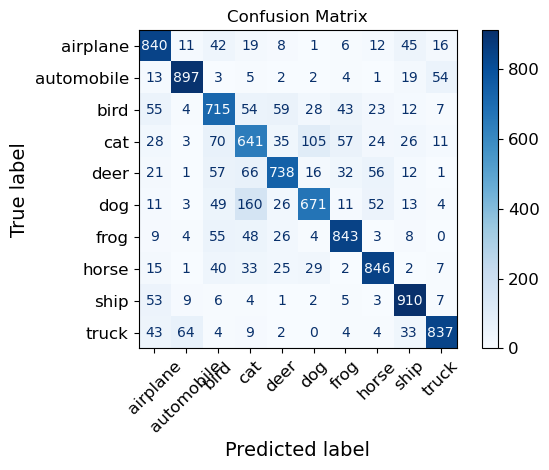

Classification Report:

              precision    recall  f1-score   support

    airplane       0.77      0.84      0.80      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.69      0.71      0.70      1000
         cat       0.62      0.64      0.63      1000
        deer       0.80      0.74      0.77      1000
         dog       0.78      0.67      0.72      1000
        frog       0.84      0.84      0.84      1000
       horse       0.83      0.85      0.84      1000
        ship       0.84      0.91      0.88      1000
       truck       0.89      0.84      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



In [139]:
evaluate_and_report(model, X_test, y_test, class_names=classNames)

# Step : Same but medium model



In [ ]:
# Get and train model "medium"
model_medium = create_model("medium") 
opt = tf.keras.optimizers.Adam()
model_medium.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_medium.summary()

history_medium = model_medium.fit(train_ds, epochs=15, validation_data=val_ds)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_224 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_253         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_225 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_254         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_226 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_255         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_227 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_256         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_228 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_257         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_229 (Conv2D)             │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_258         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_259         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.4242 - loss: 1.7097 - val_accuracy: 0.5683 - val_loss: 1.1852
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.5978 - loss: 1.1278 - val_accuracy: 0.6390 - val_loss: 1.0372
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.6779 - loss: 0.9174 - val_accuracy: 0.7135 - val_loss: 0.8032
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.7167 - loss: 0.8116 - val_accuracy: 0.7208 - val_loss: 0.8097
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.7461 - loss: 0.7292 - val_accuracy: 0.7570 - val_loss: 0.6848
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7696 - loss: 0.6640

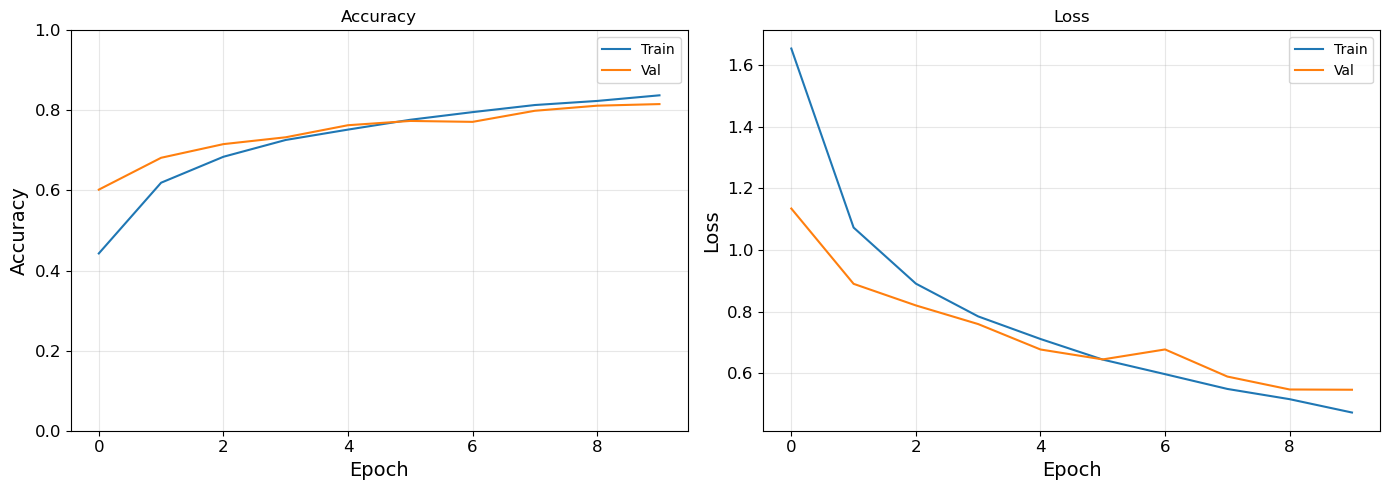

Test Accuracy: 0.8121



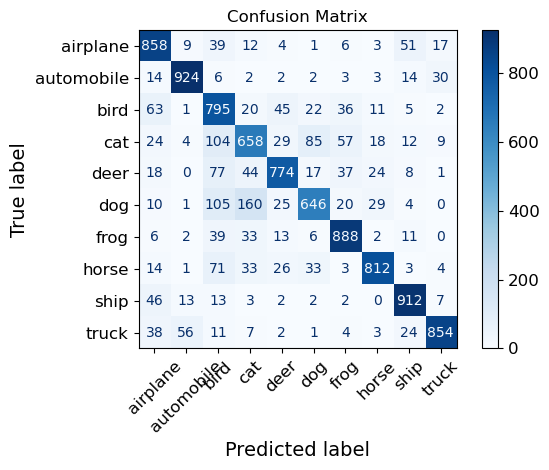

Classification Report:

              precision    recall  f1-score   support

    airplane       0.79      0.86      0.82      1000
  automobile       0.91      0.92      0.92      1000
        bird       0.63      0.80      0.70      1000
         cat       0.68      0.66      0.67      1000
        deer       0.84      0.77      0.81      1000
         dog       0.79      0.65      0.71      1000
        frog       0.84      0.89      0.86      1000
       horse       0.90      0.81      0.85      1000
        ship       0.87      0.91      0.89      1000
       truck       0.92      0.85      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



In [ ]:
plot_result(history_medium)
evaluate_and_report(model_medium, X_test, y_test, class_names=classNames)

# Step : Same but large model

In [ ]:
# Get and train model "large"
model_large = create_model("large") 
opt = tf.keras.optimizers.Adam()
model_large.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_large.summary()

history_large = model_large.fit(train_ds, epochs=25, validation_data=val_ds)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_184 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_208         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_185 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_209         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_186 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_210         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_187 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_211         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_188 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_212         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_189 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_213         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_190 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_214         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_191 (Conv2D)             │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_215         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_192 (Conv2D)             │ (None, 8, 8, 128)      │       147,58

 Total params: 747,530 (2.85 MB)

 Trainable params: 745,930 (2.85 MB)

 Non-trainable params: 1,600 (6.25 KB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 70ms/step - accuracy: 0.4196 - loss: 1.7240 - val_accuracy: 0.5739 - val_loss: 1.1947
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.6014 - loss: 1.1278 - val_accuracy: 0.6755 - val_loss: 0.9039
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.6834 - loss: 0.9021 - val_accuracy: 0.7100 - val_loss: 0.7985
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7268 - loss: 0.7817 - val_accuracy: 0.7348 - val_loss: 0.7597
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.7563 - loss: 0.7012 - val_accuracy: 0.7527 - val_loss: 0.7155
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.7838 - loss: 0.6281 - val_accuracy: 0.7751 - val_loss: 0.6642
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8054 - loss: 0.5677 - val_accuracy: 0.7935 - val_loss: 0.6094
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.8227 - loss: 0.5195 - 

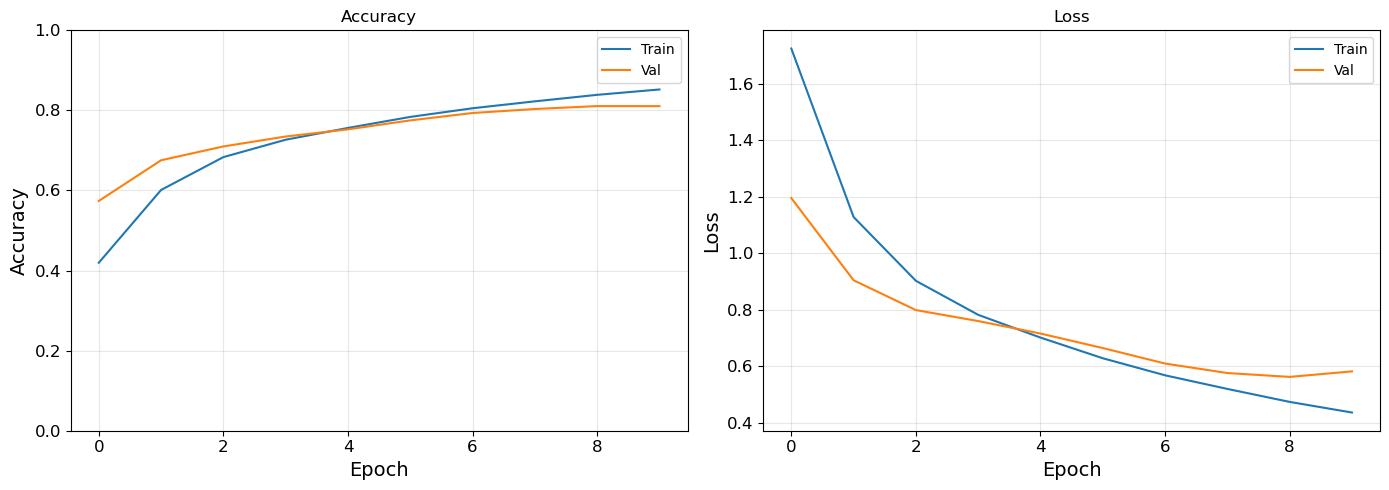

Test Accuracy: 0.8081



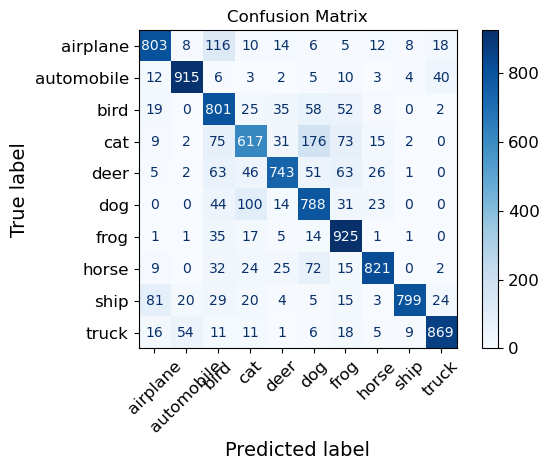

Classification Report:

              precision    recall  f1-score   support

    airplane       0.84      0.80      0.82      1000
  automobile       0.91      0.92      0.91      1000
        bird       0.66      0.80      0.72      1000
         cat       0.71      0.62      0.66      1000
        deer       0.85      0.74      0.79      1000
         dog       0.67      0.79      0.72      1000
        frog       0.77      0.93      0.84      1000
       horse       0.90      0.82      0.86      1000
        ship       0.97      0.80      0.88      1000
       truck       0.91      0.87      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



In [ ]:
plot_result(history_large)
evaluate_and_report(model_large, X_test, y_test, class_names=classNames)

# Step : Same but with large-wide model

In [ ]:
# Get and train model "large_wide"
model_large_wide = create_model("large_wide") 
opt = tf.keras.optimizers.Adam()
model_large_wide.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_large_wide.summary()

history_large_wide = model_large_wide.fit(train_ds, epochs=25, validation_data=val_ds)

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_193 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_218         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_194 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_219         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_195 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_220         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_196 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_221         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_197 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_222         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_198 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_223         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_199 (Conv2D)             │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_224         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_200 (Conv2D)             │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_225         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_201 (Conv2D)             │ (None, 8, 8, 256)      │       590,08

 Total params: 2,977,802 (11.36 MB)

 Trainable params: 2,974,602 (11.35 MB)

 Non-trainable params: 3,200 (12.50 KB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - accuracy: 0.4780 - loss: 1.5924 - val_accuracy: 0.6036 - val_loss: 1.1514
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.6659 - loss: 0.9696 - val_accuracy: 0.7113 - val_loss: 0.8637
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.7461 - loss: 0.7315 - val_accuracy: 0.7740 - val_loss: 0.6633
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.7874 - loss: 0.6167 - val_accuracy: 0.7819 - val_loss: 0.6429
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8205 - loss: 0.5247 - val_accuracy: 0.7912 - val_loss: 0.6046
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.8462 - loss: 0.4486 - val_accuracy: 0.8057 - val_loss: 0.5841
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.8683 - loss: 0.3863 - val_accuracy: 0.8250 - val_loss: 0.5243
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8852 - loss: 0.3384 - 

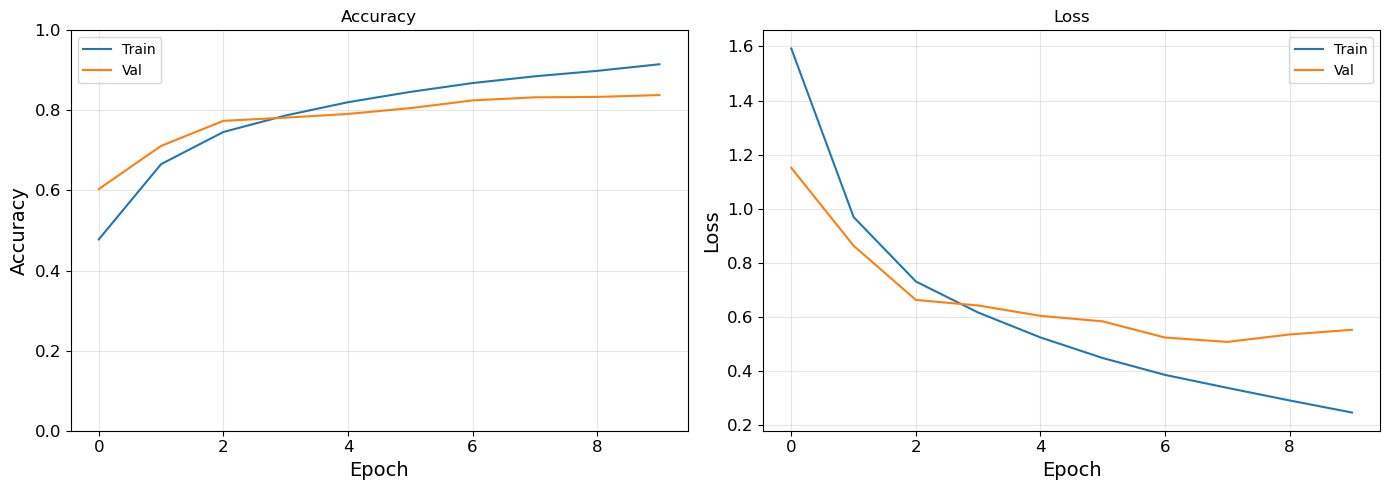

Test Accuracy: 0.8360



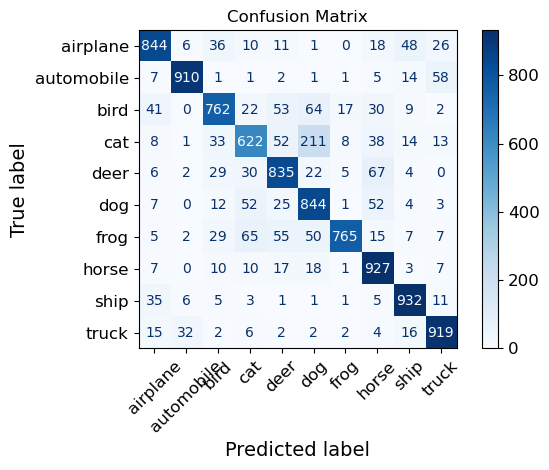

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.84      0.85      1000
  automobile       0.95      0.91      0.93      1000
        bird       0.83      0.76      0.79      1000
         cat       0.76      0.62      0.68      1000
        deer       0.79      0.83      0.81      1000
         dog       0.70      0.84      0.76      1000
        frog       0.96      0.77      0.85      1000
       horse       0.80      0.93      0.86      1000
        ship       0.89      0.93      0.91      1000
       truck       0.88      0.92      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [ ]:
plot_result(history_large_wide)
evaluate_and_report(model_large_wide, X_test, y_test, class_names=classNames)

# Step : Add callback function

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-9
)


# Step : Large_wide with callback

In [ ]:
# Get and train model "large_wide"
model_LW_ADAM_CB = create_model("large_wide") 
opt = tf.keras.optimizers.Adam()
model_LW_ADAM_CB.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_LW_ADAM_CB.summary()

history_LW_ADAM_CB = model_LW_ADAM_CB.fit(
                        train_ds, 
                        epochs=50, 
                        callbacks = [lr_scheduler],
                        verbose=1,
                        validation_data=val_ds
                        )

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_202 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_228         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_203 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_229         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_204 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_230         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_205 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_231         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_206 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_232         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_207 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_233         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_208 (Conv2D)             │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_234         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_209 (Conv2D)             │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_235         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_210 (Conv2D)             │ (None, 8, 8, 256)      │       590,08

 Total params: 2,977,802 (11.36 MB)

 Trainable params: 2,974,602 (11.35 MB)

 Non-trainable params: 3,200 (12.50 KB)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - accuracy: 0.4625 - loss: 1.6194 - val_accuracy: 0.6133 - val_loss: 1.1289 - learning_rate: 0.0010
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.6562 - loss: 0.9820 - val_accuracy: 0.7167 - val_loss: 0.8017 - learning_rate: 0.0010
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.7384 - loss: 0.7505 - val_accuracy: 0.7675 - val_loss: 0.6752 - learning_rate: 0.0010
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.7862 - loss: 0.6233 - val_accuracy: 0.7913 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.8134 - loss: 0.5413 - val_accuracy: 0.8143 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 82ms/step - accuracy: 0.8450 - loss: 0.4546 - val_accuracy: 0.7999 - val_loss: 0.6121 - learning_rate: 0.0010
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8633 - l

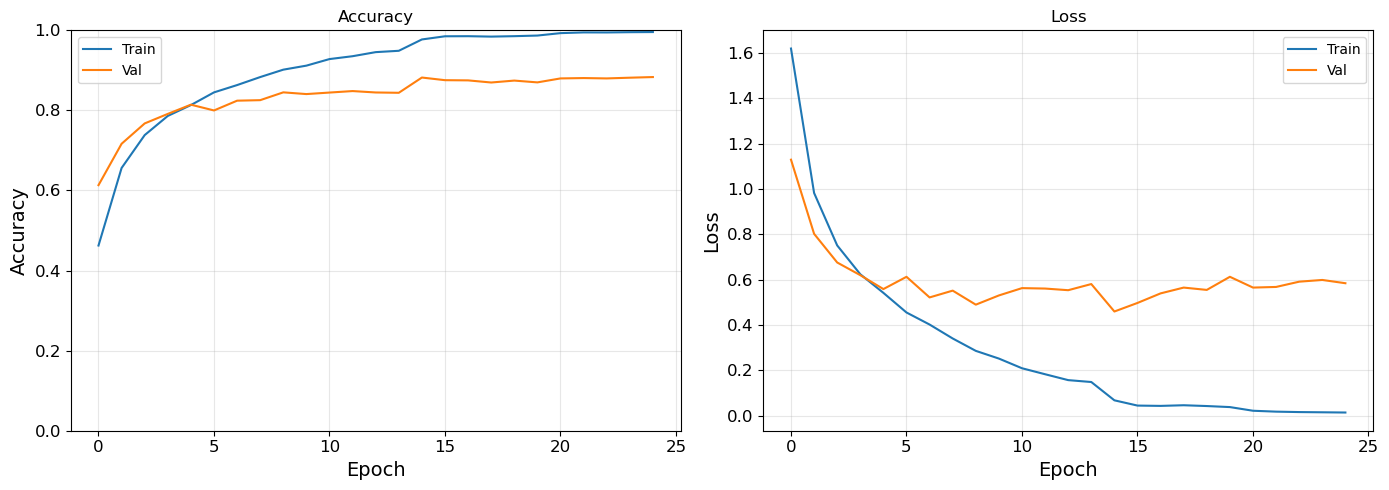

Test Accuracy: 0.8781



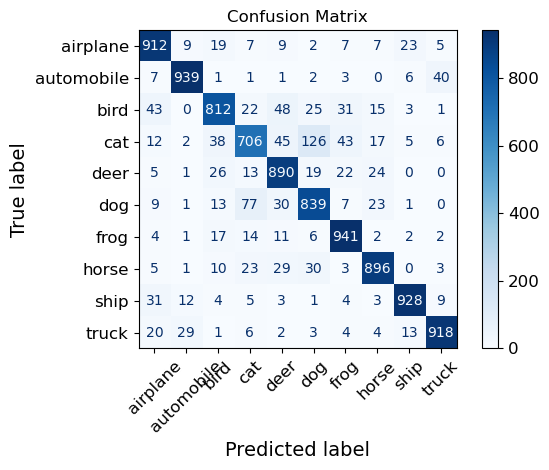

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.91      0.89      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.86      0.81      0.84      1000
         cat       0.81      0.71      0.75      1000
        deer       0.83      0.89      0.86      1000
         dog       0.80      0.84      0.82      1000
        frog       0.88      0.94      0.91      1000
       horse       0.90      0.90      0.90      1000
        ship       0.95      0.93      0.94      1000
       truck       0.93      0.92      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
plot_result(history_LW_ADAM_CB)
evaluate_and_report(model_LW_ADAM_CB, X_test, y_test, class_names=classNames)

# Step : Add simple data augmentation

In [ ]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Step : Update Preprocess for training


In [ ]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .map(lambda x, y: (augment(x, training=True), y),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train with data augmentation

In [ ]:
# Get and train model "large_wide"
model_LW_ADAM_CB_AUG = create_model("large_wide") 
opt = tf.keras.optimizers.Adam()
model_LW_ADAM_CB_AUG.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_LW_ADAM_CB_AUG.summary()

history_LW_ADAM_CB_AUG = model_LW_ADAM_CB_AUG.fit(
                        train_ds, 
                        epochs=50, 
                        callbacks = [lr_scheduler],
                        verbose=1,
                        validation_data=val_ds
                        )

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_211 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_238         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_212 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_239         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_213 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_240         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_214 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_241         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_215 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_242         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_216 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_243         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_217 (Conv2D)             │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_244         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_218 (Conv2D)             │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_245         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_219 (Conv2D)             │ (None, 8, 8, 256)      │       590,08

 Total params: 2,977,802 (11.36 MB)

 Trainable params: 2,974,602 (11.35 MB)

 Non-trainable params: 3,200 (12.50 KB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 76ms/step - accuracy: 0.4225 - loss: 1.7510 - val_accuracy: 0.5730 - val_loss: 1.3670 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.6115 - loss: 1.1113 - val_accuracy: 0.6624 - val_loss: 1.0230 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.6963 - loss: 0.8660 - val_accuracy: 0.7438 - val_loss: 0.7226 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.7397 - loss: 0.7469 - val_accuracy: 0.7483 - val_loss: 0.7430 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7726 - loss: 0.6681
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.7758 - loss: 0.6595 - val_accuracy: 0.7986 - val_loss: 0.5884 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8163 - los

KeyboardInterrupt: 

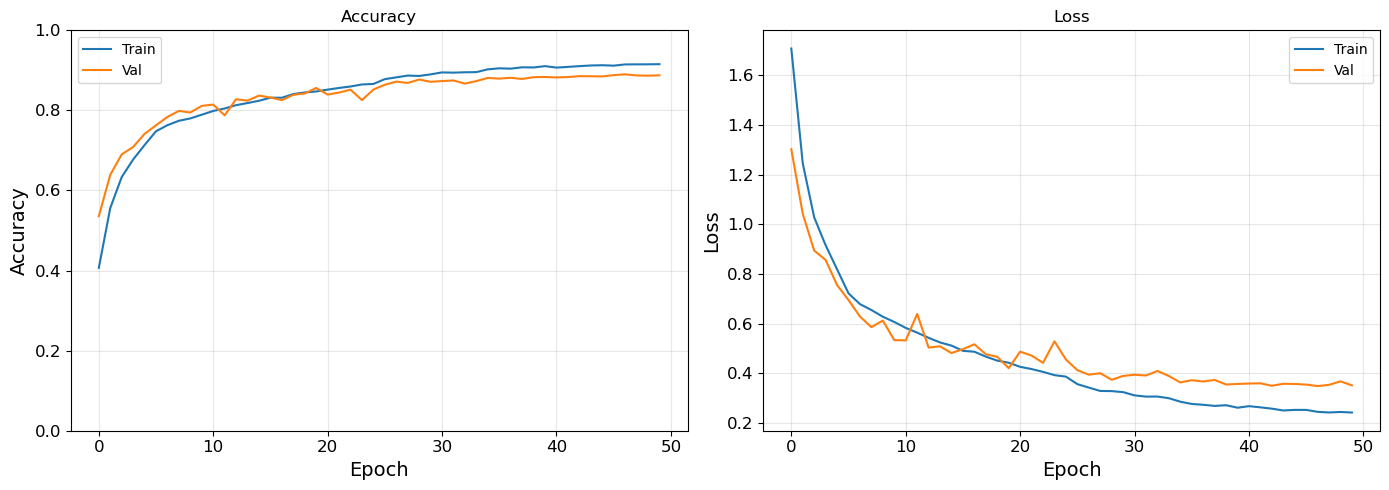

Test Accuracy: 0.8842



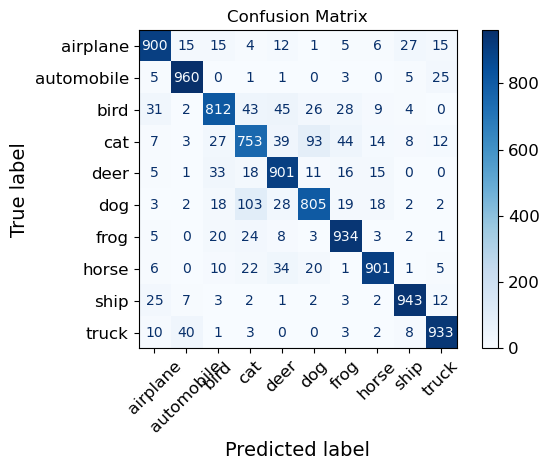

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.90      0.90      1000
  automobile       0.93      0.96      0.95      1000
        bird       0.86      0.81      0.84      1000
         cat       0.77      0.75      0.76      1000
        deer       0.84      0.90      0.87      1000
         dog       0.84      0.81      0.82      1000
        frog       0.88      0.93      0.91      1000
       horse       0.93      0.90      0.91      1000
        ship       0.94      0.94      0.94      1000
       truck       0.93      0.93      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
plot_result(history_LW_ADAM_CB_AUG)
evaluate_and_report(model_LW_ADAM_CB_AUG, X_test, y_test, class_names=classNames)

# Step : Change augmentation for cutmix

In [ ]:
def cutmix(images, labels, alpha=1.0):
    batch_size = tf.shape(images)[0]
    W = tf.shape(images)[1]
    H = tf.shape(images)[2]

    labels = tf.cast(labels, tf.float32)

    lam = tf.random.gamma([], alpha, 1.0)
    lam = lam / (lam + tf.random.gamma([], alpha, 1.0))
    lam = tf.cast(lam, tf.float32)

    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)

    rx = tf.random.uniform([], 0, W, dtype=tf.int32)
    ry = tf.random.uniform([], 0, H, dtype=tf.int32)
    rw = tf.cast(tf.cast(W, tf.float32) * tf.math.sqrt(1. - lam), tf.int32)
    rh = tf.cast(tf.cast(H, tf.float32) * tf.math.sqrt(1. - lam), tf.int32)

    x1 = tf.clip_by_value(rx - rw // 2, 0, W)
    y1 = tf.clip_by_value(ry - rh // 2, 0, H)
    x2 = tf.clip_by_value(rx + rw // 2, 0, W)
    y2 = tf.clip_by_value(ry + rh // 2, 0, H)

    mask = tf.pad(tf.ones((y2 - y1, x2 - x1, 3), dtype=tf.float32),
                  [[y1, H - y2], [x1, W - x2], [0, 0]])

    images = tf.cast(images, tf.float32)
    shuffled_images = tf.cast(shuffled_images, tf.float32)

    images = images * (1 - mask) + shuffled_images * mask
    lam = 1 - tf.cast((x2 - x1) * (y2 - y1), tf.float32) / tf.cast((W * H), tf.float32)
    labels = lam * labels + (1 - lam) * shuffled_labels
    return images, labels

def cutmix_with_prob(images, labels, alpha=1.0, prob=0.5):
    """Apply CutMix with a given probability, otherwise return original images/labels."""
    apply = tf.less(tf.random.uniform([], 0, 1), prob)
    labels = tf.cast(labels, tf.float32)  # ensure same dtype in both branches
    return tf.cond(
        apply,
        lambda: cutmix(images, labels, alpha),
        lambda: (tf.cast(images, tf.float32), labels)
    )

# Step : Update Preprocess to support cutmix with prob 0.5

In [ ]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train_new, y_train_new))
            .shuffle(10000)
            .batch(batch_size)
            .map(lambda x, y: cutmix_with_prob(x, y, alpha=1.0, prob=0.5),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


# Step : Train with cutmix

In [ ]:
# Get and train model "large_wide"
model_LW_ADAM_CB_CUT = create_model("large_wide") 
opt = tf.keras.optimizers.Adam()
model_LW_ADAM_CB_CUT.compile(
    loss="categorical_crossentropy",
    optimizer=opt, 
    metrics=['accuracy']
)

model_LW_ADAM_CB_CUT.summary()

history_LW_ADAM_CB_CUT = model_LW_ADAM_CB_CUT.fit(
                        train_ds, 
                        epochs=50, 
                        callbacks = [lr_scheduler],
                        verbose=1,
                        validation_data=val_ds
                        )

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_119 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_135         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_138         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_139         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_140         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_141         │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 8, 8, 256)      │       590,08

 Total params: 2,977,802 (11.36 MB)

 Trainable params: 2,974,602 (11.35 MB)

 Non-trainable params: 3,200 (12.50 KB)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 61ms/step - accuracy: 0.3638 - loss: 1.9243 - val_accuracy: 0.5363 - val_loss: 1.3146 - learning_rate: 0.0100
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.4963 - loss: 1.5328 - val_accuracy: 0.6313 - val_loss: 1.0360 - learning_rate: 0.0100
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.5687 - loss: 1.3697 - val_accuracy: 0.6958 - val_loss: 0.8747 - learning_rate: 0.0100
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.6184 - loss: 1.2642 - val_accuracy: 0.7250 - val_loss: 0.7977 - learning_rate: 0.0100
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6349 - loss: 1.2243
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.6471 - loss: 1.1970 - val_accuracy: 0.7453 - val_loss: 0.7570 - learning_rate: 0.0100
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.6817 - loss

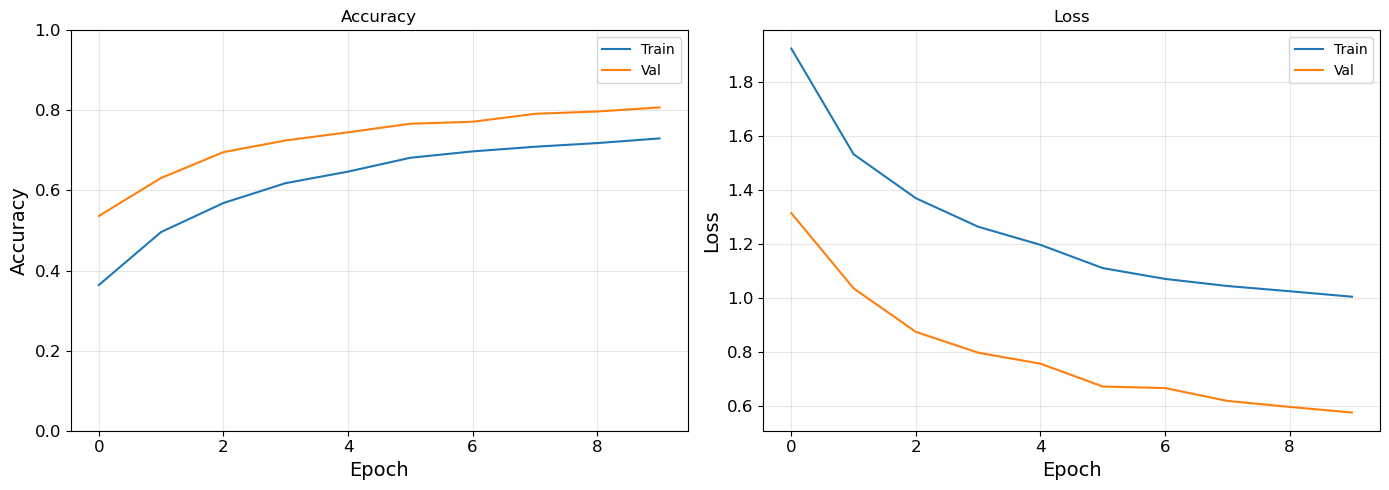

Test Accuracy: 0.5308



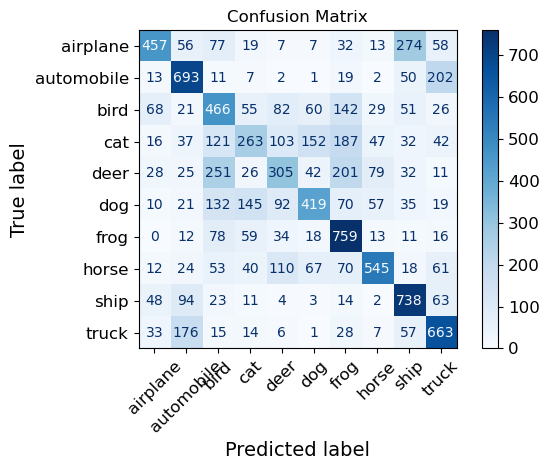

Classification Report:

              precision    recall  f1-score   support

    airplane       0.67      0.46      0.54      1000
  automobile       0.60      0.69      0.64      1000
        bird       0.38      0.47      0.42      1000
         cat       0.41      0.26      0.32      1000
        deer       0.41      0.30      0.35      1000
         dog       0.54      0.42      0.47      1000
        frog       0.50      0.76      0.60      1000
       horse       0.69      0.55      0.61      1000
        ship       0.57      0.74      0.64      1000
       truck       0.57      0.66      0.61      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.52     10000
weighted avg       0.53      0.53      0.52     10000



In [ ]:
plot_result(history_LW_ADAM_CB_CUT)
evaluate_and_report(model_LW_ADAM_CB_CUT, X_test, y_test, class_names=classNames)